In [12]:
%pylab inline

import fitsio
import seaborn as sns
from scipy.spatial import KDTree
from astropy.stats import sigma_clip
from scipy.stats import binned_statistic

sns.set(style='ticks', context='talk', rc={'figure.figsize': (16, 10)})

Populating the interactive namespace from numpy and matplotlib


Plan:

* pick some lightcurves with trends, going in opposite directions
* perform differential photometry with the raw flux to remove extinction
* see what remains

In [14]:
upward_indices = [18268, 14682, 7154, 18661, 15786]

In [3]:
fname = '../data/20150909-ng2000-802-custom-flat-high-quality.fits'

In [4]:
with fitsio.FITS(fname) as infile:
    ccdx = infile['ccdx'].read()
    ccdy = infile['ccdy'].read()

In [5]:
def compute_median(position):
    return np.median(position[:, 50:], axis=1)

In [6]:
class Tree(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self._tree = KDTree(np.vstack([self.x, self.y]).T)
        
    def neighbours(self, index, r=5):
        position = [self.x[index], self.y[index]]
        indices = self._tree.query_ball_point(position, r=r)
        return np.array(list(set(indices) - {index}))

In [7]:
med_x, med_y = [compute_median(positions) for positions in [ccdx, ccdy]]
position_tree = Tree(med_x, med_y)

In [8]:
with fitsio.FITS(fname) as infile:
    flux = infile['flux'].read()
    tamflux = infile['tamflux'].read()
    casuflux = infile['casudet'].read()
    mjd = infile['hjd'].read()

In [9]:
def format_flux(mjd, flux, bins=None, sigmas=3.):
    sc = sigma_clip(flux, sig=sigmas)
    if bins is None:
        return mjd, sc
    else:
        nbins = flux.size / bins
        by, bx, _ = binned_statistic(mjd, sc, bins=nbins)
        bc = (bx[:-1] + bx[1:]) / 2.
        return bc, by

In [10]:
def plot_lightcurve(index, points_per_bin=1):
    fig, axes = plt.subplots(3, 1, sharex=True)
    for flux_array, axis, label in zip([casuflux, tamflux, flux], axes, ['casu', 'tamuz', 'raw']):
        fx, fy = format_flux(mjd[index], flux_array[index], bins=points_per_bin)
        axis.plot(fx, fy, '.')
        axis.set(ylabel=label)
        axis.grid(True)

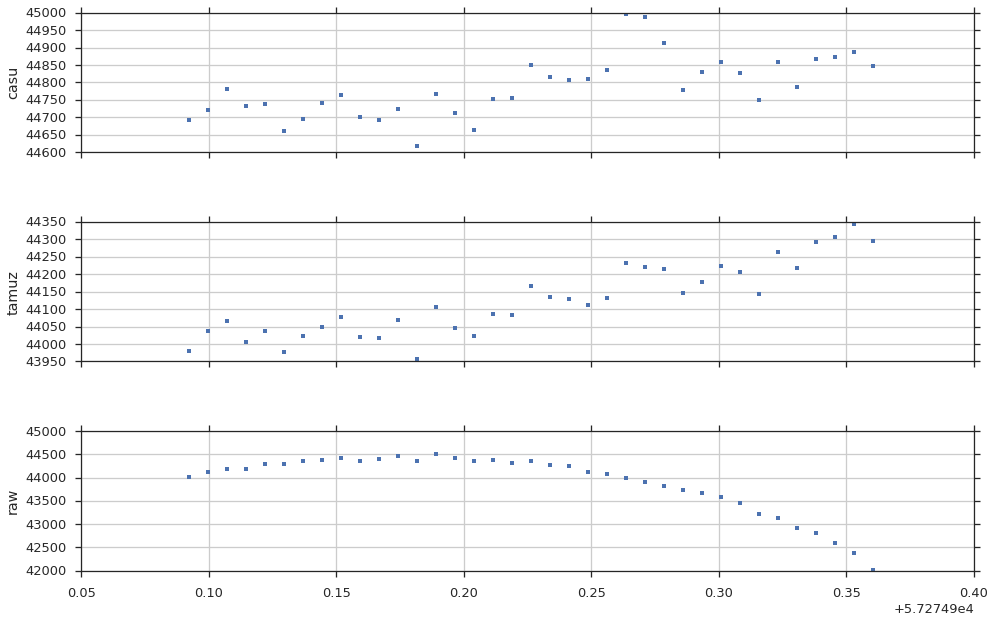

In [13]:
plot_lightcurve(18268, points_per_bin=50)